Epoch 0, Avg Loss: 587297504219.899780
Epoch 10, Avg Loss: 587288456669.470337
Epoch 20, Avg Loss: 587279319187.241577
Epoch 30, Avg Loss: 587275336485.898071
Epoch 40, Avg Loss: 587271356968.645020
Epoch 50, Avg Loss: 587271972468.989746
Epoch 60, Avg Loss: 587269122009.687988
Epoch 70, Avg Loss: 587262021105.805420
Epoch 80, Avg Loss: 587260661297.845825
Epoch 90, Avg Loss: 587256217433.784912
Epoch 100, Avg Loss: 587259243368.892578
Epoch 110, Avg Loss: 587255325705.816650
Epoch 120, Avg Loss: 587251755262.474609
Epoch 130, Avg Loss: 587248104955.994873
Epoch 140, Avg Loss: 587244483088.721313
Epoch 150, Avg Loss: 587246580220.406982
Epoch 160, Avg Loss: 587241411357.084717
Epoch 170, Avg Loss: 587237679254.792725
Epoch 180, Avg Loss: 587234120798.552368
Epoch 190, Avg Loss: 587244821456.099121
Epoch 200, Avg Loss: 587241785929.610840
Epoch 210, Avg Loss: 587238773811.407104
Epoch 220, Avg Loss: 587236022202.864624
Epoch 230, Avg Loss: 587241475949.114746
Epoch 240, Avg Loss: 587239

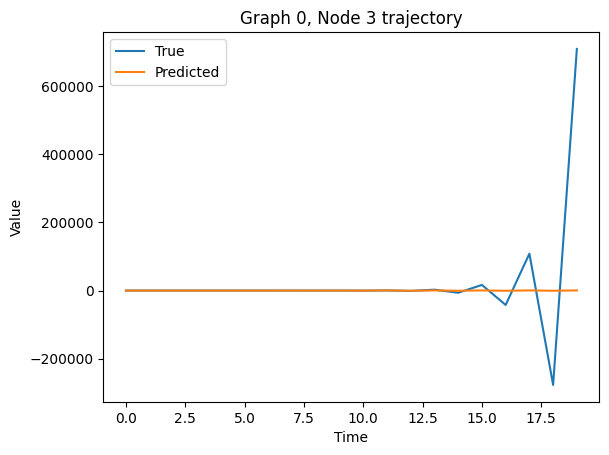

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import GConvGRU
import torch.nn.functional as F
import random

# --- 1. Generate toy multi-graph data ---

def make_synthetic_graph_dynamics(num_nodes, num_timesteps):
    """
    Create a random graph and a toy dynamic time series on it.
    Returns: edge_index, edge_weight, features_list, targets_list
    """
    # randomly generate adjacency (Erdős–Rényi)
    p = 0.2  # probability of edge
    adj = (np.random.rand(num_nodes, num_nodes) < p).astype(float)
    # make symmetric, zero diag
    adj = np.triu(adj, 1)
    adj = adj + adj.T
    np.fill_diagonal(adj, 0)
    # edge list
    row, col = np.nonzero(adj)
    edge_index = torch.tensor([row, col], dtype=torch.long)
    edge_weight = torch.tensor(adj[row, col], dtype=torch.float32)
    
    # Create synthetic dynamics: e.g. diffusion / random walk + noise
    features_list = []
    targets_list = []
    # initial values
    x = np.random.randn(num_nodes) * 0.1
    for t in range(num_timesteps):
        # one feature per node
        features_list.append(x.copy().reshape(-1, 1))  # shape (num_nodes, 1)
        # target = next-step value (simple autoregressive diffusion)
        # diffusion: new_x = x + alpha * (sum of neighbor diff) + noise
        alpha = 0.5
        # compute neighbor influence
        neigh_influence = np.zeros_like(x)
        for i, j in zip(row, col):
            neigh_influence[i] += (x[j] - x[i]) * adj[i, j]
        next_x = x + alpha * neigh_influence + np.random.randn(num_nodes) * 0.05
        targets_list.append(next_x.reshape(-1, 1))
        x = next_x
    
    # Convert lists to numpy arrays
    features_list = [f.astype(np.float32) for f in features_list]
    targets_list = [y.astype(np.float32) for y in targets_list]
    
    return edge_index, edge_weight, features_list, targets_list


# create a list of multiple simulations / graphs
multi_graph_data = []
num_graphs = 3
num_nodes = 10
num_timesteps = 20

for k in range(num_graphs):
    ei, ew, feats, targs = make_synthetic_graph_dynamics(num_nodes, num_timesteps)
    ds = StaticGraphTemporalSignal(
        edge_index=ei,
        edge_weight=ew,
        features=feats,
        targets=targs
    )
    multi_graph_data.append(ds)

# --- 2. Define your model (RecurrentGCN) ---

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super().__init__()
        self.recurrent = GConvGRU(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        out = self.linear(h)
        return out


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RecurrentGCN(node_features=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# --- 3. Training loop across multiple graphs ---

epochs = 1000

for epoch in range(epochs):
    total_loss = 0.0
    count = 0
    # optionally shuffle order of graphs each epoch
    random.shuffle(multi_graph_data)
    for ds in multi_graph_data:
        # reset hidden state of recurrent
        model.recurrent.hidden = None
        
        for snapshot in ds:
            x = snapshot.x.to(device)
            edge_index = snapshot.edge_index.to(device)
            edge_weight = snapshot.edge_attr.to(device) if snapshot.edge_attr is not None else None
            y_true = snapshot.y.to(device)
            
            optimizer.zero_grad()
            y_hat = model(x, edge_index, edge_weight)
            loss = torch.mean((y_hat - y_true)**2)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            count += 1

    avg_loss = total_loss / count
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Avg Loss: {avg_loss:.6f}")

# --- 4. Evaluate / visualize for one graph and one node ---

# pick first graph
ds0 = multi_graph_data[0]
model.eval()
node_id = 3

preds = []
trues = []

with torch.no_grad():
    model.recurrent.hidden = None
    for snapshot in ds0:
        x = snapshot.x.to(device)
        ei = snapshot.edge_index.to(device)
        ew = snapshot.edge_attr.to(device) if snapshot.edge_attr is not None else None
        y_hat = model(x, ei, ew)
        preds.append(y_hat[node_id].item())
        trues.append(snapshot.y[node_id].item())

plt.plot(trues, label='True')
plt.plot(preds, label='Predicted')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title(f"Graph 0, Node {node_id} trajectory")
plt.show()